The following code block imports some of the libraries we will be using.

In [1]:
import pathlib
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The following code block reads data from the *Orders*, *Order Details*, and *Products* tables in the *northwind.db* database. The various data is used to create an modified version of the order data, which is eventually stored in the `orders` variable, that includes information that may be useful in investigating patterns in late orders.

In [2]:
# Read select tables from database
with sqlite3.Connection('northwind.db') as conn:
    orders = pd.read_sql('SELECT * FROM Orders', conn)
    order_details = pd.read_sql('SELECT * FROM "Order Details"', conn)
    products = pd.read_sql('SELECT ProductID, ProductName, SupplierID, CategoryID FROM Products', conn)
    
order_details = order_details.merge(products, how='left')

# Get summary from order details data
order_detail_summary = order_details.groupby(
    'OrderID'
).agg(
    unique_products=('ProductID', 'nunique'),
    total_quantity=('Quantity', 'sum'),
    unique_suppliers=('SupplierID', 'nunique'),
).reset_index()

orders = orders.merge(order_detail_summary, how='left')

# Convert date columns to datetime formats
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['RequiredDate'] = pd.to_datetime(orders['RequiredDate'])
orders['ShippedDate'] = pd.to_datetime(orders['ShippedDate'])

# Limit columns to subset
columns_to_keep = [
    'OrderID', 
    'CustomerID', 
    'EmployeeID', 
    'OrderDate', 
    'RequiredDate',
    'ShippedDate', 
    'ShipVia', 
    'ShipCity', 
    'ShipCountry',
    'ShipRegion',
    'Freight',
    'unique_products', 
    'total_quantity', 
    'unique_suppliers'
]
orders = orders[columns_to_keep]

# Create date-based columns
orders['order_to_ship_days'] = (orders['ShippedDate'] - orders['OrderDate'])/pd.Timedelta(days=1)
orders['order_to_required_days'] = (orders['RequiredDate'] - orders['OrderDate'])/pd.Timedelta(days=1)
orders['lateness'] = (orders['ShippedDate'] - orders['RequiredDate'])/pd.Timedelta(days=1)
orders['late'] = (orders['lateness'] > 0).astype(int)

The following code block prints the first five rows of the `orders` object.

In [3]:
orders.head()

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,ShipCity,ShipCountry,ShipRegion,Freight,unique_products,total_quantity,unique_suppliers,order_to_ship_days,order_to_required_days,lateness,late
0,10248,VINET,5,2016-07-04,2016-08-01,2016-07-16,3,Reims,France,Western Europe,32.38,3,27,3,12.0,28.0,-16.0,0
1,10249,TOMSP,6,2016-07-05,2016-08-16,2016-07-10,1,Münster,Germany,Western Europe,11.61,2,49,2,5.0,42.0,-37.0,0
2,10250,HANAR,4,2016-07-08,2016-08-05,2016-07-12,2,Rio de Janeiro,Brazil,South America,65.83,3,60,3,4.0,28.0,-24.0,0
3,10251,VICTE,3,2016-07-08,2016-08-05,2016-07-15,1,Lyon,France,Western Europe,41.34,3,41,3,7.0,28.0,-21.0,0
4,10252,SUPRD,4,2016-07-09,2016-08-06,2016-07-11,2,Charleroi,Belgium,Western Europe,51.30,3,105,3,2.0,28.0,-26.0,0


#### Descriptive analytics

In general, analytics refers to the use of data to derive insights. Descriptive analytics is a category of analytics that focuses on using historical data to answer the question "What happened?" Oftentimes, the insights from a descriptive analytics investigation form the foundation for future analytical efforts by identifying patterns that can be leveraged for improvement, e.g., reducing employee turnover, generating recommendations, predicting contributors for a specific disease. A major component of descriptive analytics is data visualization. In the next few cells, we will consider a sequence of visualizations that focus on how the number of unique suppliers involved in an order affect the order's lateness.

The following cell generates a plot that shows the mean lateness for each of the `unique_suppliers` values that exist in our orders data. In class, we discussed some deficiencies with this visulalization. Most notabley, by estimating the lateness with a single value, namely, the mean, we have no idea of the variance in lateness. Moreover, the mean values are all smaller than 0. This correctly shows that, on average, we are not late. However, shouldn't that be expected? Instead of knowing how we perform on average, we would likely be interested in understanding if there are any patterns related to the cases where we are late.

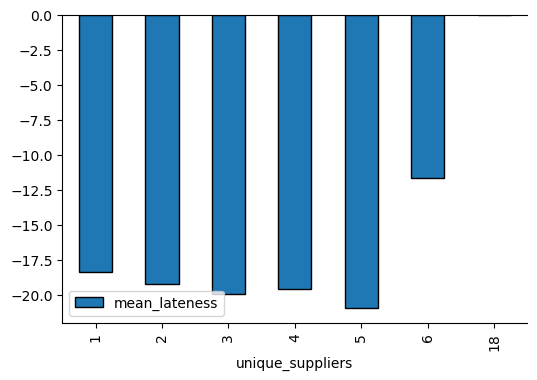

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

orders.groupby(
    'unique_suppliers'
).agg(
    mean_lateness = ('lateness', 'mean')
).plot(
    kind='bar',
    y='mean_lateness',
    ax=ax,
    edgecolor='k',
)
ax.spines[['right']].set_visible(False)

plt.show()

To clearly show that the lateness values indicated in the previous bar chart can be misleading, the following code block generates a histogram of lateness values. A vertical line is drawn where lateness equals 0, and any values higher than this correspond to late orders. As the histogram shows, although the majority of lateness values are less than or equal to zero, there are several entries above zero.

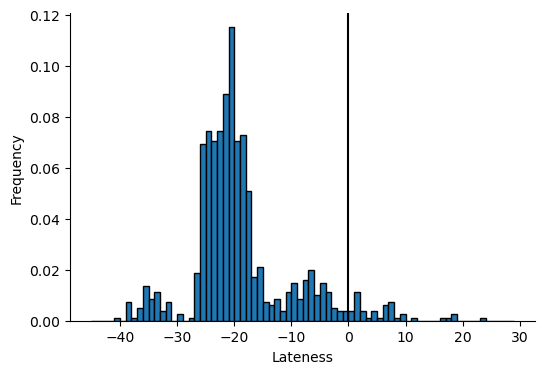

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

orders['lateness'].plot(
    kind='hist',
    bins=range(-45,30),
    edgecolor='k',
    ax=ax,
    density=True,
    xlabel='Lateness',
)
ax.axvline(0, color='k')
ax.spines[['right', 'top']].set_visible(False)

plt.show()

We will leverage the `seaborn` library for many of our descriptive visualizations. The following code block imports the library.

In [6]:
import seaborn as sns

The following code block generates a boxplot for lateness by `unique_suppliers` value. As we discussed in class, see the video, this view provides a more informative view of how the lateness can vary for each unique supplier values. Specifically, it seems that regardless of the number of unique suppliers involved in an order, we do observe late orders (cases where lateness > 0).

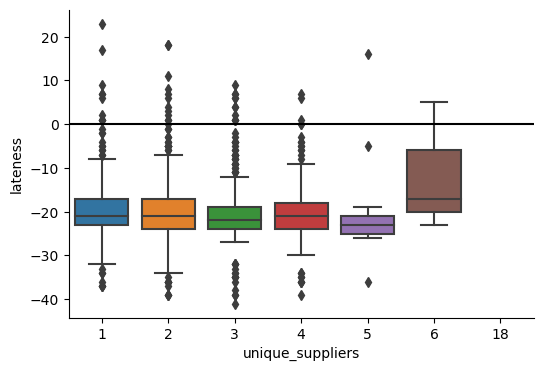

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(
    data=orders,
    x='unique_suppliers',
    y='lateness',
)
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(0, color='k')

plt.show()

The previously shown boxplot is great in the sense that it provides much better insight regarding the distribution of lateness for each value in the `unique_suppliers` column, it still does not let us make any claims regarding differences among them. For this purpose, the following code block uses `seaborn`'s `pointplot` function to generate 95% confidence intervals for the mean lateness by `unique_suppliers` values. The width of a confidence interval is influenced by both: 1) the number of observations that are used to compute the interval and 2) the variance of the observations. For example, in class, we saw that we only have three orders where the number of `unique_suppliers` is 6, which contributes to the much wider confidence intervals we observe for this case. The fact that all of the confidence intervals overlap means that we cannot say there is any statistically significant differene in the mean lateness due to the number of unique suppliers that contribute to an order.

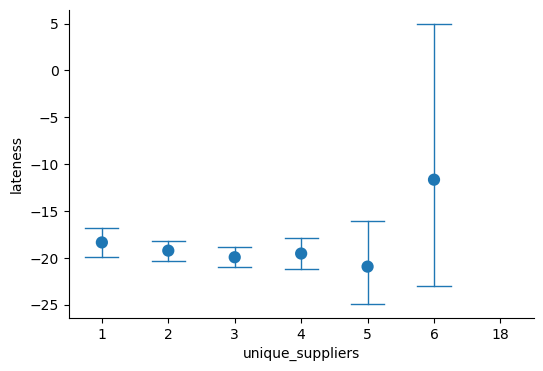

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.pointplot(
    data=orders,
    x='unique_suppliers',
    y='lateness',
    join=False,
    errwidth=1.0,
    capsize=0.5,
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

The following code block simply puts the two subplots in a single figure.

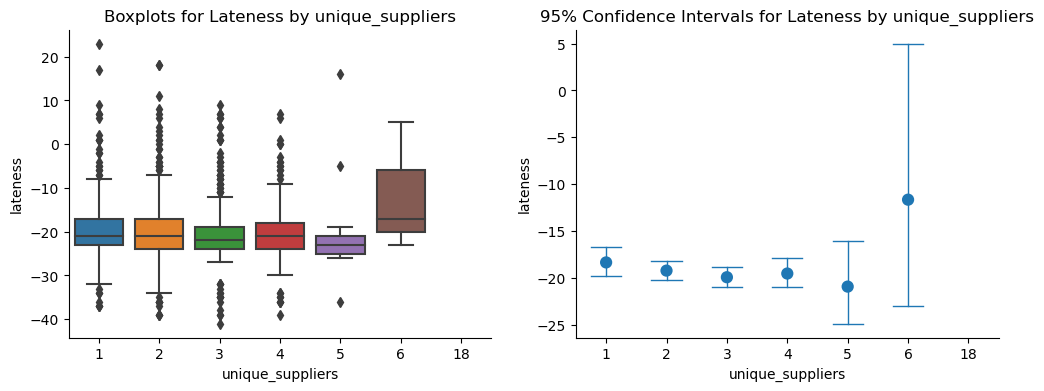

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(
    data=orders,
    x='unique_suppliers',
    y='lateness',
    ax=ax[0],
)
ax[0].set_title('Boxplots for Lateness by unique_suppliers')
ax[0].spines[['right', 'top']].set_visible(False)

sns.pointplot(
    data=orders,
    x='unique_suppliers',
    y='lateness',
    join=False,
    errwidth=1.0,
    capsize=0.5,
    ax=ax[1]
)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title('95% Confidence Intervals for Lateness by unique_suppliers')
plt.show()

The `boxplot` and `pointplot` methods used to generate the plots in the previous cell should be applied when the categories we want to compare are a discrete set (countable, not infinite) and have a relatively small number of categories. To demonstrate what happens if we use them in a case where the number of categories is large, the following code block uses the `pointplot` function to generate 95% confidence intervals for `lateness` for the various values of `total_quantity` we observe in the orders data. As you can see, the resulting plot is a mess and fails to communicate any clear insights.

/home/nick/miniconda3/envs/om421_env/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


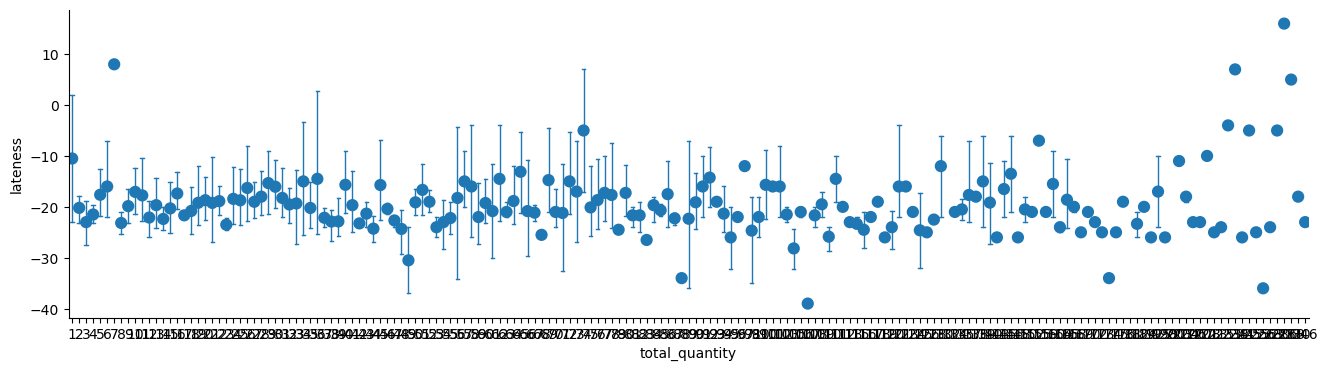

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

sns.pointplot(
    data=orders,
    x='total_quantity',
    y='lateness',
    join=False,
    errwidth=1.0,
    capsize=0.5,
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

A better choice in a situation like that above is to use a regression analysis to see if there is any trend in variable plotted on the vertical (y) axis as the variable plotted on the horizontal (x) axis varies. This can be achieved using the `regplot` function in seaborn, which is shown in the following code block.

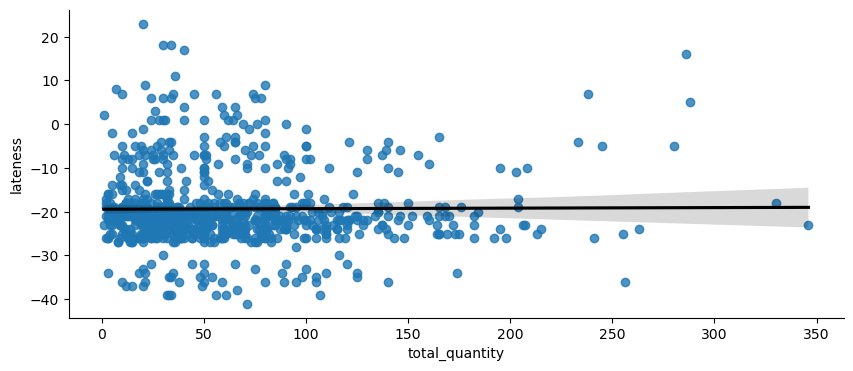

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.regplot(
    data=orders,
    x='total_quantity',
    y='lateness',
    line_kws={'color':'k'},
)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

Sometimes, we want to see what happens as more than one variable vary. The following code block uses a `pointplot` to show 95% confidence intervals for the mean value of the `late` column, essentially capturing a confidence interval for the proportion of late orders, as both the `ShipRegion` and `ShipVia` values vary. Notice that we use the `hue` argument, in addition to the `x` argument, to specify the variables to be varied along the horizontal axis. Since we have three distint values for the `hue` variable (1, 2, and 3), specifying three markers allows us to better distinguish the confidence intervals for each `hue` level. 

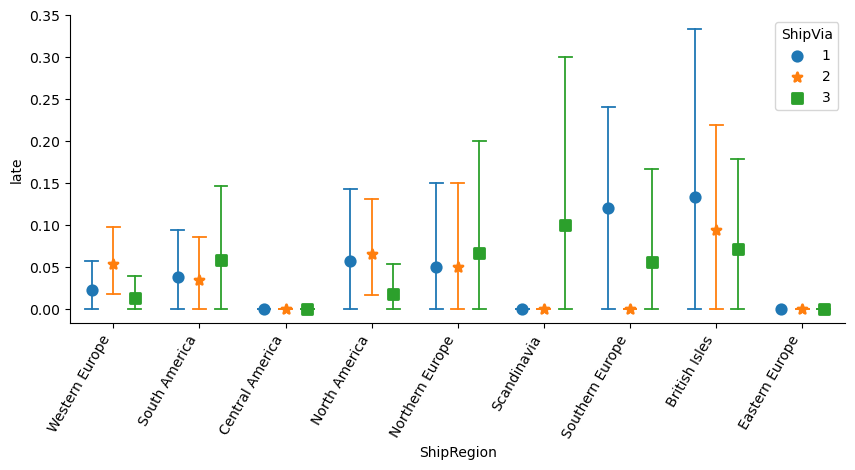

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.pointplot(
    data=orders,
    x='ShipRegion',
    y='late',
    hue='ShipVia',
    markers=['o', '*', 's'],
    join=False,
    errwidth=1.3,
    capsize=0.15,
    dodge=0.5,
)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    ha='right',
)

plt.show()

The final plot type that we will look at (for now at least) is a heatmap. Heatmaps are also useful for showing how values change as two variables vary. We will use a heatmap to show the Pearson correlation coefficient (see https://en.wikipedia.org/wiki/Pearson_correlation_coefficient for a refresher) for pairwise combinations of the `unique_products`, `total_quantity`, `unique_suppliers`, and `late` columns. The following code block computes the correlation coefficient for these columns using the `corr` method of a `pandas` `DataFrame`.

In [13]:
columns = [
    'unique_products', 
    'total_quantity', 
    'unique_suppliers', 
    'late',
]

corr_matrix = orders[columns].corr()

The following code block generates the heatmap. Note that I specify the lower and upper bounds for the values to be -1 and 1 using the `vmin` and `vmax` arguments, respectively. Also, I use the `coolwarm` colormap (`cmap`), add annotations (`annot=True`), and format the annotations to show floating-point numbers with 2 decimal places (`fmt='.2f'`). Regardless of how good your analysis is, a bad visualization can render your work meaningless. Thus, taking the time to style your visualizations for easy interpretation is **very important**. The following heatmap shows that also there are high degrees of positive correlation between the `unique_products`, `total_quantity`, and `unique_suppliers` variables, none of them exhibit a high degree of correlation (positive or negative) with the `late` values.

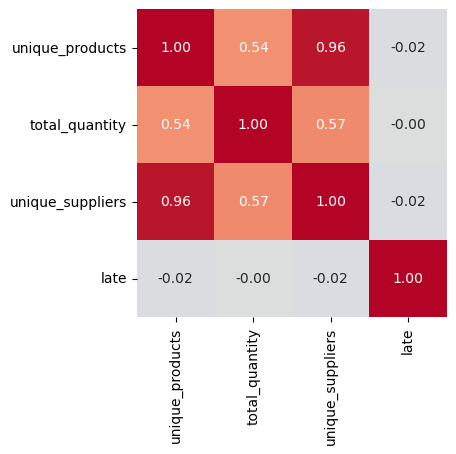

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    vmin=-1.0,
    vmax=1.0,
    cmap='coolwarm',
    annot=True,
    cbar=False,
    fmt='.2f',
)

ax.spines[['right', 'top']].set_visible(False)

plt.show()